# Deep-Learning with Keras on Amazon SageMaker with ANN from the Superdatascience course

See: https://www.superdatascience.com/courses/deep-learning-az

In [1]:
!pip install pydot

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Step 1: Download the data set 
The data sets are needed to train our Neural Network. We use the Churn_Modelling data set from the Superdatascience courses

In [2]:
!wget https://s3-ap-southeast-1.amazonaws.com/sgavinio-machine-learning-datasets/Churn_Modelling.csv

--2019-03-13 12:11:08--  https://s3-ap-southeast-1.amazonaws.com/sgavinio-machine-learning-datasets/Churn_Modelling.csv
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.32.105
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.32.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 684858 (669K) [text/csv]
Saving to: ‘Churn_Modelling.csv.1’

Churn_Modelling.csv 100%[===================>] 668.81K  --.-KB/s    in 0.01s   

2019-03-13 12:11:08 (60.5 MB/s) - ‘Churn_Modelling.csv.1’ saved [684858/684858]



## Step 2.1: Pre-process the data

Read the data set and encode categorical features.

In [2]:
# Start pre-processing template
import numpy as np
import pandas as pd

dataset = pd.read_csv("Churn_Modelling.csv")
features = dataset[[
        "CreditScore", 
        "Geography", 
        "Gender", 
        "Age", 
        "Tenure", 
        "Balance", 
        "NumOfProducts", 
        "HasCrCard", 
        "IsActiveMember", 
        "EstimatedSalary"
]]
output = dataset[["Exited"]]

# Convert dataframes to Arrays
X = features.values
y = output.values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode the categorical features: Gender and Geography
labelencoder_geography = LabelEncoder()
labelencoder_gender = LabelEncoder()
X[:, 1] = labelencoder_geography.fit_transform(X[:, 1])
X[:, 2] = labelencoder_gender.fit_transform(X[:, 2])
# We only one-hot-encode the geography, the age only has two values and will result in a dummy variable trap
# See n - 1 dummy variable rule
onehotencoder_geography = OneHotEncoder(categorical_features = [1])
X = onehotencoder_geography.fit_transform(X).toarray()
# We eliminate the first dummy variable from the geography: n - 1 dummy variable rule
X = X[:, 1:]

## Step 2.2: Split the data set into the training and test sets

In [3]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Step 2.3: Feature Scale the dependent variables

In [4]:
# Feature scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Step 3: Push the pre-processed data set to S3

Push the the processed train and test data sets to S3 such that they can be consumed easier during the training phase.

In [5]:
# if this produces an error, don't sweat it. Just means you already have the directory.
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [6]:
%%time

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
s3_bucket = sess.default_bucket()
s3_prefix = 'churn_modeling'

arn:aws:iam::572101368213:role/service-role/AmazonSageMaker-ExecutionRole-20181228T215310
CPU times: user 665 ms, sys: 80.9 ms, total: 746 ms
Wall time: 5.33 s


In [7]:
np.save('./data/train_X.npy', X_train)
np.save('./data/train_Y.npy', y_train)
np.save('./data/test_X.npy', X_test)
np.save('./data/test_Y.npy', y_test)

In [8]:
data_s3_prefix = '{}/data'.format(s3_prefix)

In [9]:
data_dir = sess.upload_data(path='./data/', bucket=s3_bucket, key_prefix=data_s3_prefix)

## Step 4: Build the Artificial Neural Network

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [11]:
def keras_model_fn(hyperparameters):
    # Define the layers
    classifier = Sequential()
    # relu is rectifier activation function
    # Dense is simple fully-connected layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu", input_dim = 11, name = "inputs"))
    # Second hidden layer, no need to define inpout_dim, this layer is automatically linked to the first layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu"))
    # Output layer
    classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid"))
    # Compile the ANN, configure back-propagation
    # adam is a type of stochastic gradient descent, binary_crossentropy is used for binary outputs
    classifier.compile(optimizer = hyperparameters["optimizer"], loss = "binary_crossentropy", metrics = ["accuracy"])

    return classifier

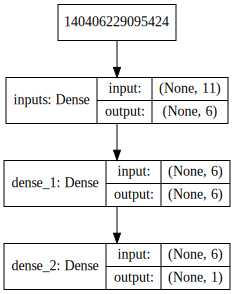

In [12]:
classifier=keras_model_fn({"optimizer": "adam"})
SVG(model_to_dot(classifier,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

## Step 5: Train on the notebook instance to verify

As a sanity check before launching a SageMaker training job, we train the model on the notebook instance to check that all is well.

In [13]:
classifier.summary()
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (Dense)               (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8000/8000 [==============================] - 2s 300us/step - loss: 0.4770 - acc: 0.7955
Epoch 2/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.4260 - acc: 0.7960
Epoch 3/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.4202 - acc: 0.8092
Epoch 4/100
8000/8000 [==============================] - 1s 144us/step - loss: 0.4168 - acc: 0.8247
Epoch 5/

8000/8000 [==============================] - 1s 184us/step - loss: 0.3997 - acc: 0.8350
Epoch 76/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3997 - acc: 0.8345
Epoch 77/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3999 - acc: 0.8351
Epoch 78/100
8000/8000 [==============================] - 1s 144us/step - loss: 0.3996 - acc: 0.8339
Epoch 79/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3993 - acc: 0.8364
Epoch 80/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3994 - acc: 0.8366
Epoch 81/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3996 - acc: 0.8355
Epoch 82/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3993 - acc: 0.8355
Epoch 83/100
8000/8000 [==============================] - 1s 144us/step - loss: 0.3996 - acc: 0.8341
Epoch 84/100
8000/8000 [==============================] - 1s 144us/step - loss: 0.3987 - acc: 0.8351
Epo

## Step 6: Train as a SageMaker training job

The TensorFlow estimator uses the `keras_ann.py` script as the entrypoint. Give special attention to the `keras_model_fn` which was re-defined within this python script.

In [14]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point="keras_ann.py",
    role=role,
    framework_version="1.12.0",
    train_instance_count=1, 
    train_instance_type="ml.c4.xlarge",
    training_steps=8000, 
    evaluation_steps=2000,
    hyperparameters={'optimizer': 'adam'}
)
tf_estimator.fit(data_dir)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-2019-03-14-12-48-08-905


2019-03-14 12:48:11 Starting - Starting the training job...
2019-03-14 12:48:12 Starting - Launching requested ML instances......
2019-03-14 12:49:18 Starting - Preparing the instances for training...
2019-03-14 12:50:11 Downloading - Downloading input data
2019-03-14 12:50:11 Training - Training image download completed. Training in progress..
2019-03-14 12:50:11,666 INFO - root - running container entrypoint
2019-03-14 12:50:11,667 INFO - root - starting train task
2019-03-14 12:50:11,680 INFO - container_support.training - Training starting
2019-03-14 12:50:14,384 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2019-03-14 12:50:14,385 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2019-03-14 12:50:14,385 INFO - tf_container - ---------------------------------------------------------
2019-03-14 12:50:14,385 INFO - tf_container - creating RunConfig:
2019-03-14 12:50:14,385 I

2019-03-14 12:50:28,537 INFO - tensorflow - global_step/sec: 314.301
2019-03-14 12:50:28,537 INFO - tensorflow - loss = 0.37557322, step = 1101 (0.318 sec)
2019-03-14 12:50:28,847 INFO - tensorflow - global_step/sec: 322.416
2019-03-14 12:50:28,847 INFO - tensorflow - loss = 0.36113197, step = 1201 (0.310 sec)
2019-03-14 12:50:29,163 INFO - tensorflow - global_step/sec: 316.019
2019-03-14 12:50:29,163 INFO - tensorflow - loss = 0.35054445, step = 1301 (0.316 sec)
2019-03-14 12:50:29,476 INFO - tensorflow - global_step/sec: 319.919
2019-03-14 12:50:29,476 INFO - tensorflow - loss = 0.34305322, step = 1401 (0.313 sec)
2019-03-14 12:50:29,864 INFO - tensorflow - global_step/sec: 257.482
2019-03-14 12:50:29,864 INFO - tensorflow - loss = 0.33858612, step = 1501 (0.388 sec)
2019-03-14 12:50:30,172 INFO - tensorflow - global_step/sec: 324.635
2019-03-14 12:50:30,173 INFO - tensorflow - loss = 0.33624345, step = 1601 (0.308 sec)
2019-03-14 12:50:30,486 INFO - tensorflow - global_step/sec: 318

2019-03-14 12:50:48,376 INFO - tensorflow - global_step/sec: 334.587
2019-03-14 12:50:48,377 INFO - tensorflow - loss = 0.32822496, step = 7301 (0.299 sec)
2019-03-14 12:50:48,764 INFO - tensorflow - global_step/sec: 258.007
2019-03-14 12:50:48,764 INFO - tensorflow - loss = 0.32822466, step = 7401 (0.388 sec)
2019-03-14 12:50:49,078 INFO - tensorflow - global_step/sec: 318.149
2019-03-14 12:50:49,079 INFO - tensorflow - loss = 0.32822645, step = 7501 (0.314 sec)
2019-03-14 12:50:49,380 INFO - tensorflow - global_step/sec: 331.585
2019-03-14 12:50:49,380 INFO - tensorflow - loss = 0.3282257, step = 7601 (0.302 sec)
2019-03-14 12:50:49,692 INFO - tensorflow - global_step/sec: 320.091
2019-03-14 12:50:49,692 INFO - tensorflow - loss = 0.32822478, step = 7701 (0.312 sec)
2019-03-14 12:50:49,993 INFO - tensorflow - global_step/sec: 332.053
2019-03-14 12:50:49,994 INFO - tensorflow - loss = 0.32822454, step = 7801 (0.301 sec)
2019-03-14 12:50:50,319 INFO - tensorflow - global_step/sec: 306.

### Optional: Train using TensorFlow ScriptMode

The above SageMaker training invocation executes the training and validation using the TensorFlow Legacy mode. To run using the newer ScriptMode, execute the following cell instead.

Because you have flexibility of how to perform training and validation when running in ScriptMode, it easier to configure the hyperparameters such as the batch_size and epochs.

See: https://docs.aws.amazon.com/sagemaker/latest/dg/tf.html

In [ ]:
# Based-off: https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/keras-embeddings-script-mode/keras-embeddings.ipynb

from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point="keras_ann_script_mode.py",
    role=role,
    framework_version="1.12.0",
    train_instance_count=1, 
    train_instance_type="ml.c4.xlarge",
    hyperparameters={'learning_rate': 0.1, 
                     'epochs': 100, 
                     'batch_size': 10},
    script_mode=True
)

tf_estimator.fit({'train': data_dir, 'eval': data_dir})

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-03-14-12-56-16-177


2019-03-14 12:56:18 Starting - Starting the training job...
2019-03-14 12:56:20 Starting - Launching requested ML instances......
2019-03-14 12:57:21 Starting - Preparing the instances for training...
2019-03-14 12:58:11 Downloading - Downloading input data...
2019-03-14 12:58:27 Training - Training image download completed. Training in progress.
2019-03-14 12:58:30,476 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-03-14 12:58:30,483 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-14 12:58:30,915 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-14 12:58:30,934 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-14 12:58:30,946 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "module_dir": "s3://sagemaker-ap-southeast-1-572101368213/sagemaker-tensorflow-scriptmode-2019-03-14-12-56-16-177/source/sourcedir.tar.gz"

#015  10/8000 [..............................] - ETA: 1s - loss: 0.9280 - acc: 0.5000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 340/8000 [>.............................] - ETA: 1s - loss: 0.5333 - acc: 0.7794#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 640/8000 [=>............................] - ETA: 1s - loss: 0.5241 - acc: 0.7859#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.6336 - acc: 0.7000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 330/8000 [>.............................] - ETA: 1s - loss: 0.4451 - acc: 0.8394#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 650/8000 [=>............................] - ETA: 1s - loss: 0.4845 - acc: 0.8154#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 2s - loss: 0.5085 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 330/8000 [>.............................] - ETA: 1s - loss: 0.4982 - acc: 0.8061#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 650/8000 [=>............................] - ETA: 1s - loss: 0.4899 - acc: 0.8108#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.7512 - acc: 0.6000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.5125 - acc: 0.7969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 640/8000 [=>............................] - ETA: 1s - loss: 0.4957 - acc: 0.8062#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 2s - loss: 0.3783 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 330/8000 [>.............................] - ETA: 1s - loss: 0.5036 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 630/8000 [=>............................] - ETA: 1s - loss: 0.4925 - acc: 0.8079#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.3945 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.5051 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 620/8000 [=>............................] - ETA: 1s - loss: 0.5131 - acc: 0.7935#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.6798 - acc: 0.7000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.5841 - acc: 0.7469#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 650/8000 [=>............................] - ETA: 1s - loss: 0.5364 - acc: 0.7815#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 2s - loss: 0.5179 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 270/8000 [>.............................] - ETA: 1s - loss: 0.5141 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 600/8000 [=>............................] - ETA: 1s - loss: 0.4953 - acc: 0.8100#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#